In [1]:
%pylab inline

import os
import pandas as pd
from collections import OrderedDict
from astropy.io import fits
from tools.EW import equivalent_width
from tools.Photometry import ABmag
from tools.ParseFITS import merge_stellar_nebular
from tools.stats import norm2one
from scipy.ndimage import gaussian_filter
from styles import slides

Populating the interactive namespace from numpy and matplotlib


In [2]:
rdir = os.path.expandvars("$HOME/Research/photometric-ew")

sdss_res = loadtxt("{}/data/SDSS_filters.txt".format(rdir))
sdss_res = [
    sdss_res[:47],
    sdss_res[47:47+89],
    sdss_res[47+89:47+89+75],
    sdss_res[47+89+75:47+89+75+89],
    sdss_res[47+89+75+89:]
]
jpas = open("{}/data/JPAS_filters.txt".format(rdir)).readlines()

mask = [False if item.startswith("#") else True for item in jpas]
jpas_res = []
for i in xrange(mask.count(False)):
    try:
        ini = mask.index(False); mask.remove(False)
        fin = mask.index(False)
        
        jpas_res.append(np.array([eval(item.replace("  ", ",")) for item in jpas[ini+1+i:fin+1+i]]))
        
    except ValueError:
        jpas_res.append(np.array([eval(item.replace("  ", ",")) for item in jpas[ini+1+i:]]))

In [3]:
flist = sorted([os.path.join(root,file) for root,subs,files in os.walk("{}/models/PEGASE/".format(rdir)) for file in files if file.endswith(".fits.gz")])

models_tot = OrderedDict()
models_ste = OrderedDict()
Z_ste, Z_neb = OrderedDict(), OrderedDict()
for file in flist:
    f = fits.open(file)
    
    Z_ste[f[2].data["Zstars"][0]] = f[2].data["Zstars"]
    Z_neb[f[2].data["Zstars"][0]] = f[2].data["Zgas"]
    
    ages, SEDs_ste, SEDs_tot = merge_stellar_nebular(f)
    
    models_ste[f[2].data["Zstars"][0]] = SEDs_ste
    models_tot[f[2].data["Zstars"][0]] = SEDs_tot

ew_sdss = pd.read_csv("{}/data/photo-speclines.csv".format(rdir), index_col="FITS")
ew_sdss.dropna(axis="index", subset=["H_alpha", "u", "r"], inplace=True)

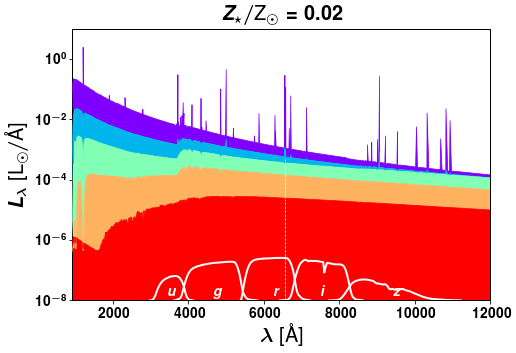

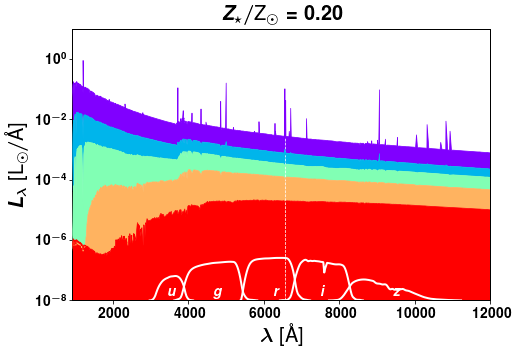

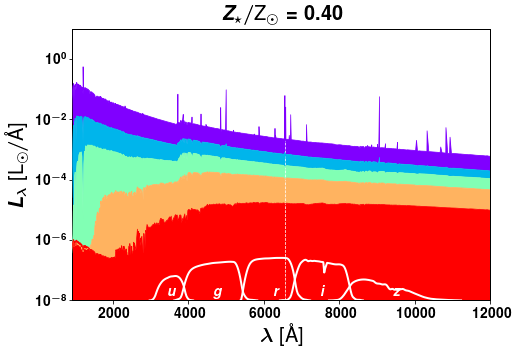

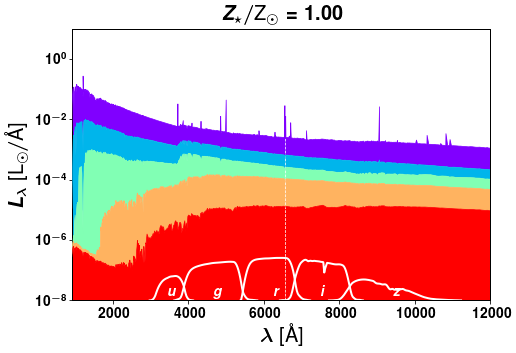

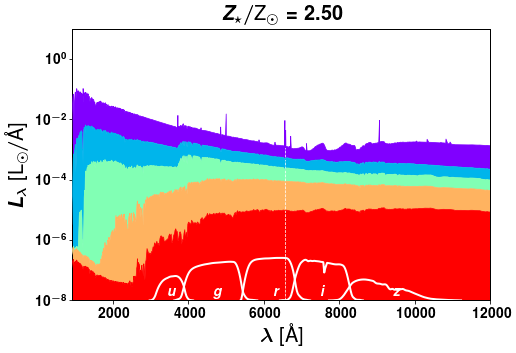

In [4]:
columns = ["10 Myr","50 Myr","200 Myr","1000 Myr", "13000 Myr"]
colors = cm.rainbow(linspace(0,1,len(columns)))

band_nms = [r"$u$",r"$g$",r"$r$",r"$i$",r"$z$"]
mets_val = array(sorted(Z_ste.keys()))

for k in xrange(mets_val.size):
    fig, ax = subplots(1, 1, figsize=(7.5,5))
    ax.set_yscale("log")

    SEDs_tot = models_tot[mets_val[k]]
    SEDs_sel = SEDs_tot.get(columns).values
    for j in xrange(len(columns)):
        if j<len(columns)-1:
            ax.fill_between(SEDs_tot.index.values, SEDs_sel[:,j], SEDs_sel[:,j+1], facecolor=colors[j], lw=0)
        else:
            ax.fill_between(SEDs_tot.index.values, SEDs_sel[:,j], 1e-35, facecolor=colors[j], lw=0)
        ax.plot(SEDs_tot.index.values, SEDs_sel[:,j], color=colors[j], lw=0.75, zorder=999)
    for i,band in enumerate(sdss_res):
        ax.plot(band[:,0], (band[:,1])/0.2e7+1e-8, color="w")
        ax.text((band[0,0]+band[-1,0])*0.5, 1.15e-8, band_nms[i], va="bottom", ha="center", color="w", size="x-small")
    ax.axvline(6562, lw=0.75, ls="--", color="w")
    ax.set_xlim(912,12000)
    ax.set_ylim(1e-8,10)
    ax.set_title(r"$Z_\star/\text{Z}_\odot=%.2f$"%(mets_val[k]/0.02))
    ax.set_xlabel(r"$\lambda$ [\AA]")
    ax.set_ylabel(r"$L_\lambda$ [L$_{\odot}/$\AA]")

In [5]:
# First Approach to the colour-EW correlation
# In rest-frame, compute the SDSS colours
ur_neb = OrderedDict()#zeros(ages.size)
ur_ste = OrderedDict()#zeros(ages.size)
ew_neb = OrderedDict()#zeros(ages.size)
ur_exc = OrderedDict()
for Z in mets_val:
    SEDs_tot = models_tot[Z]
    SEDs_ste = models_ste[Z]
    
    ur_neb[Z], ur_ste[Z], ew_neb[Z] = [], [], []
    for j in xrange(ages.size):
        SED_neb_j = column_stack((SEDs_tot.index.values,SEDs_tot.get(SEDs_tot.columns[j])))
        SED_ste_j = column_stack((SEDs_ste.index.values,SEDs_ste.get(SEDs_ste.columns[j])))

        ur_neb[Z] += [ABmag(SED_neb_j, sdss_res[0]) - ABmag(SED_neb_j, sdss_res[2])]
        ur_ste[Z] += [ABmag(SED_ste_j, sdss_res[0]) - ABmag(SED_ste_j, sdss_res[2])]
        ew_neb[Z] += [equivalent_width(SED_neb_j, (6562,), (40,))[0]]
    # Compute the colour excess
    ur_neb[Z], ur_ste[Z], ew_neb[Z] = array(ur_neb[Z]), array(ur_ste[Z]), array(ew_neb[Z])
    ur_exc[Z] = ur_ste[Z] - ur_neb[Z]

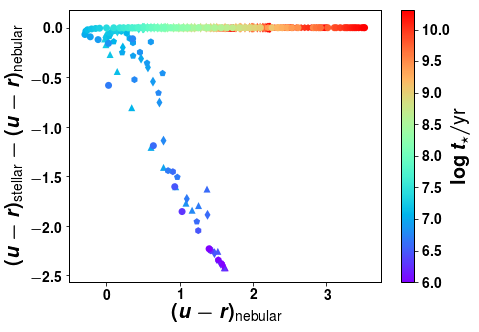

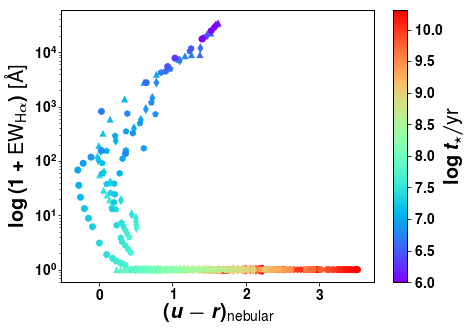

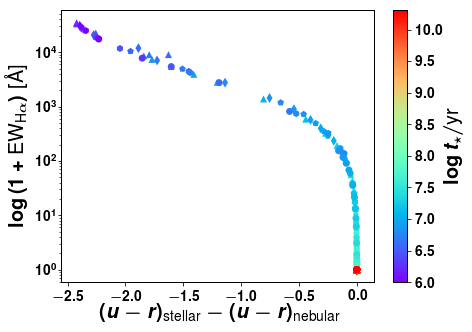

In [6]:
markers = OrderedDict(zip(mets_val,["^","d","p","h","o"]))

# Plot the colour vs the colour-excess (this should show an anti-correlation)
figure(figsize=(7,5))
for Z in mets_val: scatter(ur_neb[Z], ur_exc[Z], marker=markers[Z], c=log10(ages.values), lw=0, cmap=cm.rainbow)
cb = colorbar()
xlabel(r"$(u-r)_\text{nebular}$")
ylabel(r"$(u-r)_\text{stellar}-(u-r)_\text{nebular}$")
cb.set_label(r"$\log{t_\star/\text{yr}}$")

figure(figsize=(7,5))
for Z in mets_val: scatter(ur_neb[Z], 1+ew_neb[Z], marker=markers[Z], c=log10(ages.values), lw=0, cmap=cm.rainbow)
cb = colorbar()
xlabel(r"$(u-r)_\text{nebular}$")
gca().set_yscale("log")
ylabel(r"$\log{\left(1+\text{EW}_{\text{H}\alpha}\right)}$ [\AA]")
cb.set_label(r"$\log{t_\star/\text{yr}}$")

figure(figsize=(7,5))
for Z in mets_val: scatter(ur_exc[Z], 1+ew_neb[Z], marker=markers[Z], c=log10(ages.values), lw=0, cmap=cm.rainbow)
cb = colorbar()
xlabel(r"$(u-r)_\text{stellar}-(u-r)_\text{nebular}$")
gca().set_yscale("log")
ylabel(r"$\log{\left(1+\text{EW}_{\text{H}\alpha}\right)}$ [\AA]")
cb.set_label(r"$\log{t_\star/\text{yr}}$")

# This will help separate the age-nebular emission relation

In [7]:
# NEXT STEPS

# simulate redshift sample
z_in, z_fi = ew_sdss.redshift.min(), ew_sdss.redshift.max()
redshift = linspace(z_in, z_fi, 1000)
# define probability distribution for redshift assignment according to age(~mass~colour)
PDF_age = lambda t, z: exp((0.5*z+0.05)*t)
# simulate SDSS photometry for that sample using:
#    SEDs with nebular emission
#    SEDs with pure stellar emission
ur_neb_z = OrderedDict()
ur_ste_z = OrderedDict()
ew_neb_z = OrderedDict()
ages_z = OrderedDict()
for Z in mets_val:
    SEDs_tot = models_tot[Z]
    SEDs_ste = models_ste[Z]
    
    ages_z[Z], ur_neb_z[Z], ur_ste_z[Z], ew_neb_z[Z] = [], [], [], []
    for j,z in enumerate(redshift):
        weights = PDF_age(log10(ages.values), z)
        weights /= weights.sum()
        i = random.choice(ages.index)

        SED_neb_z = column_stack((SEDs_tot.index.values*(z+1),SEDs_tot.get(SEDs_tot.columns[i])))
        SED_ste_z = column_stack((SEDs_ste.index.values*(z+1),SEDs_ste.get(SEDs_ste.columns[i])))

        ages_z[Z] += [log10(ages.get(i))]
        ur_neb_z[Z] += [ABmag(SED_neb_z, sdss_res[0]) - ABmag(SED_neb_z, sdss_res[2])]
        ur_ste_z[Z] += [ABmag(SED_ste_z, sdss_res[0]) - ABmag(SED_ste_z, sdss_res[2])]
        ew_neb_z[Z] += [equivalent_width(SED_neb_z, (6562*(z+1),), (40*(z+1),))[0]]
    ages_z[Z], ur_neb_z[Z], ur_ste_z[Z], ew_neb_z[Z] = array(ages_z[Z]), array(ur_neb_z[Z]), array(ur_ste_z[Z]), array(ew_neb_z[Z])

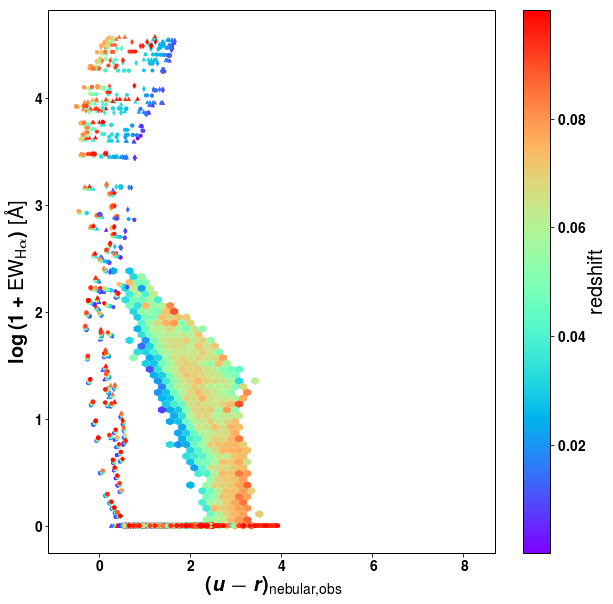

In [8]:
# plot SDSS data
ur_obs = ew_sdss.u-ew_sdss.r
mask = ew_sdss.H_alpha>=0.0
#mask = ew_sdss.H_alpha.values < 0
hexbin(ur_obs[mask], log10((ew_sdss.H_alpha[mask])+1), ew_sdss.redshift[mask], (55,30), vmin=z_in, vmax=z_fi, linewidths=0, cmap=cm.rainbow, reduce_C_function=median, mincnt=5)

# plot colour vs colour excess (stellar - nebular) vs redshift
for Z in mets_val: scatter(ur_neb_z[Z], log10(1+ew_neb_z[Z]), marker=markers[Z], c=redshift, s=20, lw=0, cmap=cm.rainbow, zorder=999)
cb = colorbar()
xlabel(r"$(u-r)_\text{nebular,obs}$")
ylabel(r"$\log{\left(1+\text{EW}_{\text{H}\alpha}\right)}$ [\AA]")
cb.set_label(r"$\text{redshift}$")
# cb.set_label(r"$\log{t_\star/\text{yr}}$")
#ylim(-10,500)
# show surveys sample selection cuts (e.g., r<17.7)

/home/mejia/Projects/miniconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0,0.5,u'$N$')

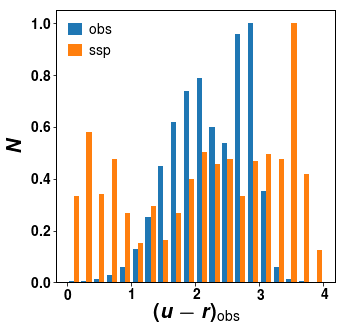

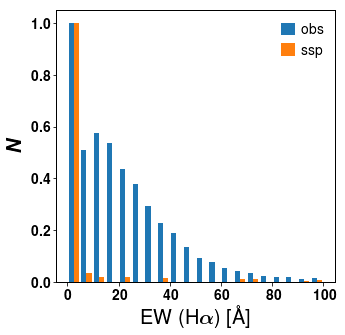

In [9]:
figure(figsize=(5,5))
hist([ur_obs,ur_neb_z[mets_val[4]]], 20, range=(0,4), label=["obs","ssp"], weights=[norm2one(ur_obs,20,(0,4)),norm2one(ur_neb_z[mets_val[4]],20,(0,4))])
legend(loc=0)
xlabel(r"$(u-r)_\text{obs}$")
ylabel(r"$N$")

figure(figsize=(5,5))
hist([ew_sdss.H_alpha,ew_neb_z[mets_val[4]]], 20, range=(0,100), label=["obs","ssp"], weights=[norm2one(ew_sdss.H_alpha,20,(0,100)),norm2one(ew_neb_z[mets_val[4]],20,(0,100))])
legend(loc=0)
xlabel(r"EW (H$\alpha$) [\AA]")
ylabel(r"$N$")

In [10]:
bins = linspace(0, 3, 6)
ew_groups = ew_sdss.H_alpha.groupby(pd.cut(ur_obs,bins))

print ew_groups.count()
print ew_groups.agg([mean,std])

(0.0, 0.6]      135
(0.6, 1.2]     1127
(1.2, 1.8]     6858
(1.8, 2.4]    11062
(2.4, 3.0]    12958
Name: H_alpha, dtype: int64
                  mean         std
(0.0, 0.6]  291.421616  272.299956
(0.6, 1.2]   97.006261   91.050648
(1.2, 1.8]   38.453337   20.485782
(1.8, 2.4]   18.751280   12.439256
(2.4, 3.0]    2.150357    7.300828
